In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Unzip source files

In [2]:
! unzip '/content/drive/My Drive/Colab Notebooks/Snakes in the hood/8a95c26e1bab11eb.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/b70a166bfe.jpg  
  inflating: dataset/train/d31875b68e.jpg  
  inflating: dataset/train/22c66793fb.jpg  
  inflating: dataset/train/a468b1390f.jpg  
  inflating: dataset/train/9e43d2cedc.jpg  
  inflating: dataset/train/2e0299e991.jpg  
  inflating: dataset/train/e0b85d8ff1.jpg  
  inflating: dataset/train/6a651ec04a.jpg  
  inflating: dataset/train/46c87716a5.jpg  
  inflating: dataset/train/8c40d4f073.jpg  
  inflating: dataset/train/96e4fb744c.jpg  
  inflating: dataset/train/794a698960.jpg  
  inflating: dataset/train/dad1934f35.jpg  
  inflating: dataset/train/a1c66a2b3c.jpg  
  inflating: dataset/train/b62484a8e4.jpg  
  inflating: dataset/train/09462814f1.jpg  
  inflating: dataset/train/97dbdb4dd0.jpg  
  inflating: dataset/train/3bd7f56164.jpg  
  inflating: dataset/train/a2576a2fa1.jpg  
  inflating: dataset/train/f462f66aa6.jpg  
  inflating: dataset/train/740e1a7fca.jpg  
  inflating: dataset/trai

## Importing Packages

In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

## Helper Function

In [4]:
def adjust_gamma(image, gamma=1.0):
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	return cv2.LUT(image, table)

## Set file path for training and test images

In [5]:
train_img_path = "dataset/train"
test_img_path = "dataset/test"
train_true_label = "dataset/train.csv"
test_file = "dataset/test.csv"

## Data Preprocessing

### Read train/test dataset

In [6]:
train_true_label_df = pd.read_csv(train_true_label)
train_true_label_df['breed_enc'] = train_true_label_df['breed'].factorize()[0]
train_true_label_df.head()

,image_id,breed,breed_enc
0,a8b3ad1dde,nerodia-erythrogaster,0
1,8b492b973d,pantherophis-vulpinus,1
2,929b99ea92,thamnophis-sirtalis,2
3,bbac7385e2,pantherophis-obsoletus,3
4,ef776b1488,agkistrodon-contortrix,4


In [7]:
test_df = pd.read_csv(test_file)
test_df.head()

,image_id
0,7ede553357
1,3500b219e4
2,d43a78d6d9
3,1f36f26994
4,8cb85fc58e


### EDA on train/test images resolution

In [8]:
train_img_list = []

for file in tqdm(train_true_label_df['image_id']):
    file_path = train_img_path + "/" + file + ".jpg"
    img = cv2.imread(file_path)
    train_img_list.append((file, img.shape[0], img.shape[1]))

train_df = pd.DataFrame(train_img_list, columns =['image_id', 'Height', 'Width'])
train_df = pd.merge(train_df, train_true_label_df, how='inner', on='image_id')
train_df.head()

100%|██████████| 5508/5508 [00:02<00:00, 2148.39it/s]


,image_id,Height,Width,breed,breed_enc
0,a8b3ad1dde,72,128,nerodia-erythrogaster,0
1,8b492b973d,171,128,pantherophis-vulpinus,1
2,929b99ea92,171,128,thamnophis-sirtalis,2
3,bbac7385e2,228,128,pantherophis-obsoletus,3
4,ef776b1488,171,128,agkistrodon-contortrix,4


In [9]:
test_df = pd.read_csv(test_file)
test_img_list = []

for file in tqdm(test_df['image_id']):
    file_path = test_img_path + "/" + file + ".jpg"
    img = cv2.imread(file_path)
    test_img_list.append((file, img.shape[0], img.shape[1]))

test_df = pd.DataFrame(test_img_list, columns =['image_id', 'Height', 'Width'])
test_df.head()

100%|██████████| 2361/2361 [00:01<00:00, 2119.26it/s]


,image_id,Height,Width
0,7ede553357,171,128
1,3500b219e4,96,128
2,d43a78d6d9,112,128
3,1f36f26994,171,128
4,8cb85fc58e,233,128


In [10]:
train_df['height_bin'] = train_df['Height'].apply(lambda x: 64 if x<=90 else 128 if x>90 and x<171 else 256)
test_df['height_bin'] = test_df['Height'].apply(lambda x: 64 if x<=90 else 128 if x>90 and x<171 else 256)

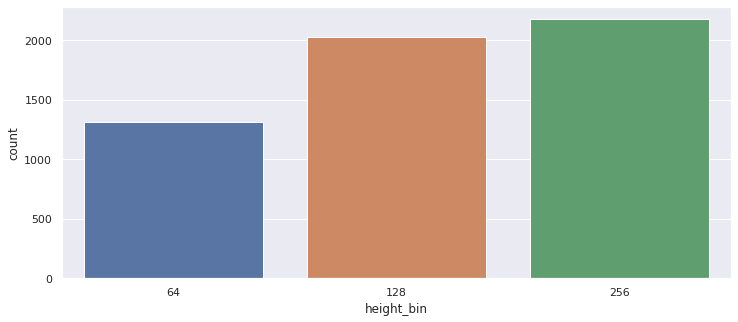

In [11]:
plt.figure(figsize=(12,5))
sns.set(style="darkgrid")
ax = sns.countplot(x="height_bin", data=train_df)

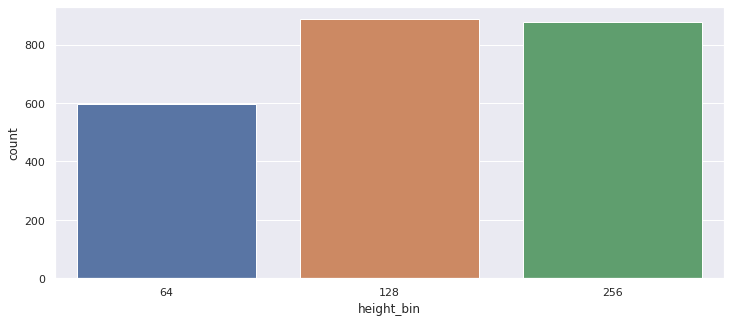

In [12]:
plt.figure(figsize=(12,5))
sns.set(style="darkgrid")
ax = sns.countplot(x="height_bin", data=test_df)

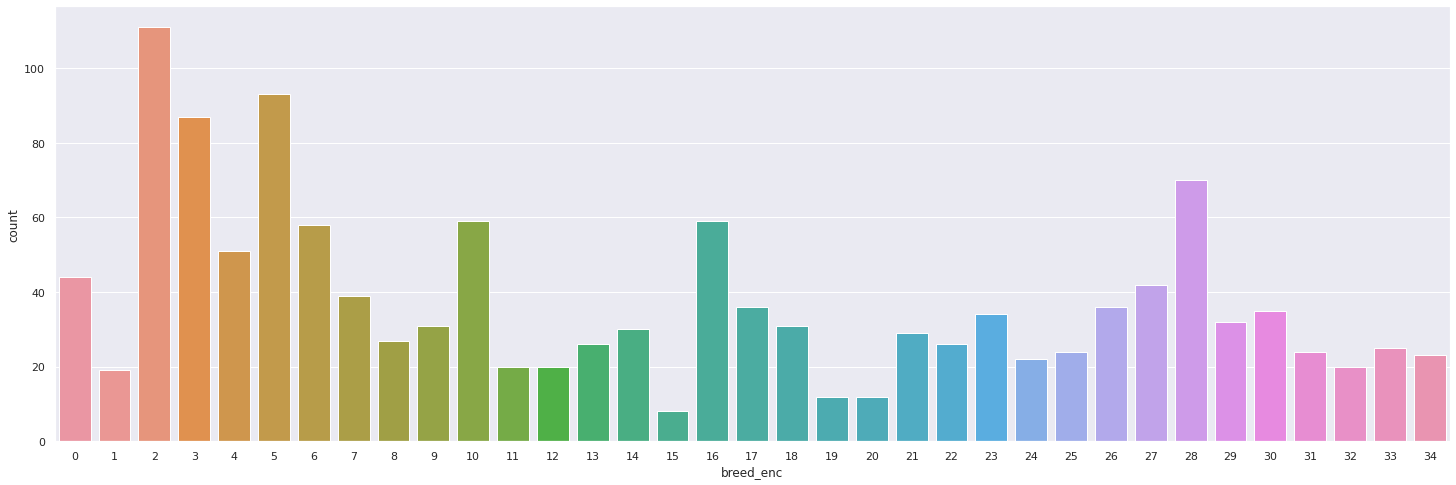

In [13]:
tmp_df = train_df[train_df['height_bin']==64]
plt.figure(figsize=(25,8))
sns.set(style="darkgrid")
ax = sns.countplot(x="breed_enc", data=tmp_df)

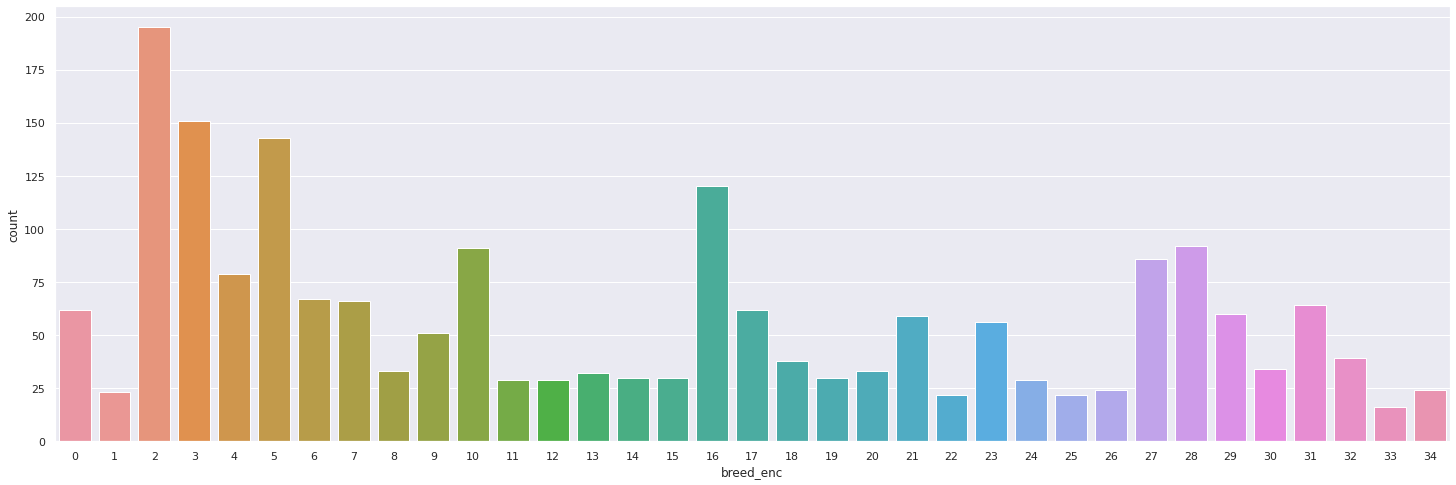

In [14]:
tmp_df = train_df[train_df['height_bin']==128]
plt.figure(figsize=(25,8))
sns.set(style="darkgrid")
ax = sns.countplot(x="breed_enc", data=tmp_df)

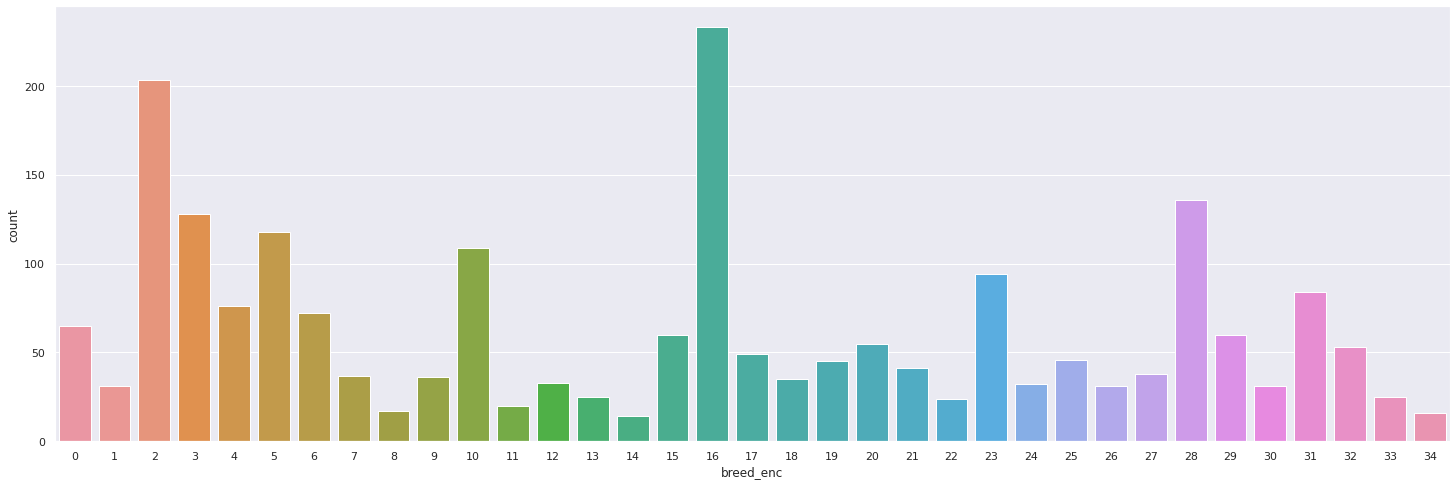

In [15]:
tmp_df = train_df[train_df['height_bin']==256]
plt.figure(figsize=(25,8))
sns.set(style="darkgrid")
ax = sns.countplot(x="breed_enc", data=tmp_df)

### Create true-label matrices for every image resolution

In [16]:
Ytrain = np.array([train_df['breed_enc']]).T
print(Ytrain.shape)

# Calculate class-weights
temp_df = pd.DataFrame(Ytrain, columns=['target'])
temp_df = temp_df.groupby(['target']).size().reset_index().rename(columns={0:'count'})
total_count = np.sum(temp_df['count'].values)
temp_df['class%'] = (temp_df['count'] / total_count) * 100
lowest_pct = min(temp_df['class%'])
temp_df['class_weight'] = lowest_pct / temp_df['class%']
class_weight = temp_df[['target', 'class_weight']].to_dict()['class_weight']
class_weight

(5508, 1)


{0: 0.3684210526315789,
 1: 0.863013698630137,
 2: 0.12377210216110018,
 3: 0.17213114754098358,
 4: 0.3058252427184466,
 5: 0.17796610169491525,
 6: 0.31979695431472077,
 7: 0.44366197183098594,
 8: 0.8181818181818181,
 9: 0.5338983050847457,
 10: 0.24324324324324323,
 11: 0.9130434782608695,
 12: 0.7682926829268292,
 13: 0.7590361445783133,
 14: 0.8513513513513513,
 15: 0.6428571428571428,
 16: 0.1529126213592233,
 17: 0.42857142857142855,
 18: 0.6057692307692307,
 19: 0.7241379310344828,
 20: 0.6299999999999999,
 21: 0.48837209302325585,
 22: 0.8749999999999999,
 23: 0.3423913043478261,
 24: 0.7590361445783133,
 25: 0.6847826086956522,
 26: 0.6923076923076922,
 27: 0.3795180722891566,
 28: 0.21140939597315436,
 29: 0.4144736842105263,
 30: 0.6299999999999999,
 31: 0.36627906976744184,
 32: 0.5625,
 33: 0.9545454545454546,
 34: 1.0}

### Create feature matrix for train/test images

In [23]:
image_group = []

for idx in tqdm(range(train_df.shape[0])):

    file = train_df.iloc[idx]['image_id']
    img_hgt = train_df.iloc[idx]['height_bin']

    # Set file path for input image
    file_path = train_img_path + "/" + file + ".jpg"
    
    # Read input image using OpenCV
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, img_hgt), 
                     interpolation = cv2.INTER_NEAREST)
    img = adjust_gamma(img, 0.5)
    image_group.append(img)

# Construct an image batch object
image_batch = np.zeros((len(image_group),) + (256, 128, 3), dtype='float32')

# Copy all images to the upper left part of the image batch object
for image_index, image in enumerate(image_group):
    image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

# Scale the raw pixel intensities to the range [0, 1]
Xtrain = np.array(image_batch, dtype="float32") / 255.0
print(Xtrain.shape)

100%|██████████| 5508/5508 [00:10<00:00, 518.39it/s]


(5508, 256, 128, 3)


In [24]:
image_group = []

for idx in tqdm(range(test_df.shape[0])):

    file = test_df.iloc[idx]['image_id']
    img_hgt = test_df.iloc[idx]['height_bin']

    # Set file path for input image
    file_path = test_img_path + "/" + file + ".jpg"
    
    # Read input image using OpenCV
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, img_hgt),
                     interpolation = cv2.INTER_NEAREST)
    img = adjust_gamma(img, 0.5)
    image_group.append(img)

# Construct an image batch object
image_batch = np.zeros((len(image_group),) + (256, 128, 3), dtype='float32')

# Copy all images to the upper left part of the image batch object
for image_index, image in enumerate(image_group):
    image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

# Scale the raw pixel intensities to the range [0, 1]
Xpredict = np.array(image_batch, dtype="float32") / 255.0
print(Xpredict.shape)

100%|██████████| 2361/2361 [00:04<00:00, 525.39it/s]


(2361, 256, 128, 3)


## Save the datasets in NPZ files (for reusability)

In [25]:
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/Snakes in the hood/Snake_images_dataset.npz',
                    Xtrain=Xtrain, Ytrain=Ytrain, Xpredict=Xpredict)

## Display sample images

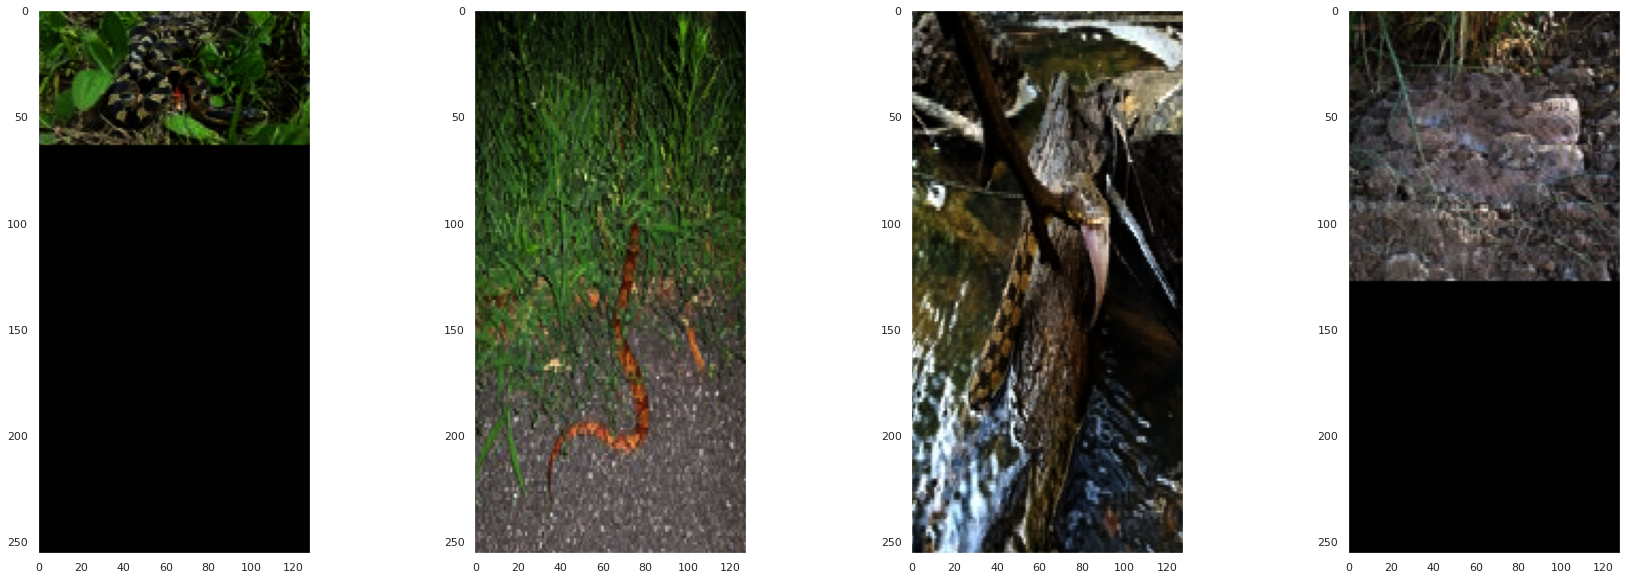

In [30]:
_, ax = plt.subplots(1, 4, figsize=(30, 10))
ax[0].imshow(Xtrain[10]); ax[0].grid(False);
ax[1].imshow(Xtrain[100]); ax[1].grid(False);
ax[2].imshow(Xtrain[1000]); ax[2].grid(False);
ax[3].imshow(Xtrain[5000]); ax[3].grid(False);

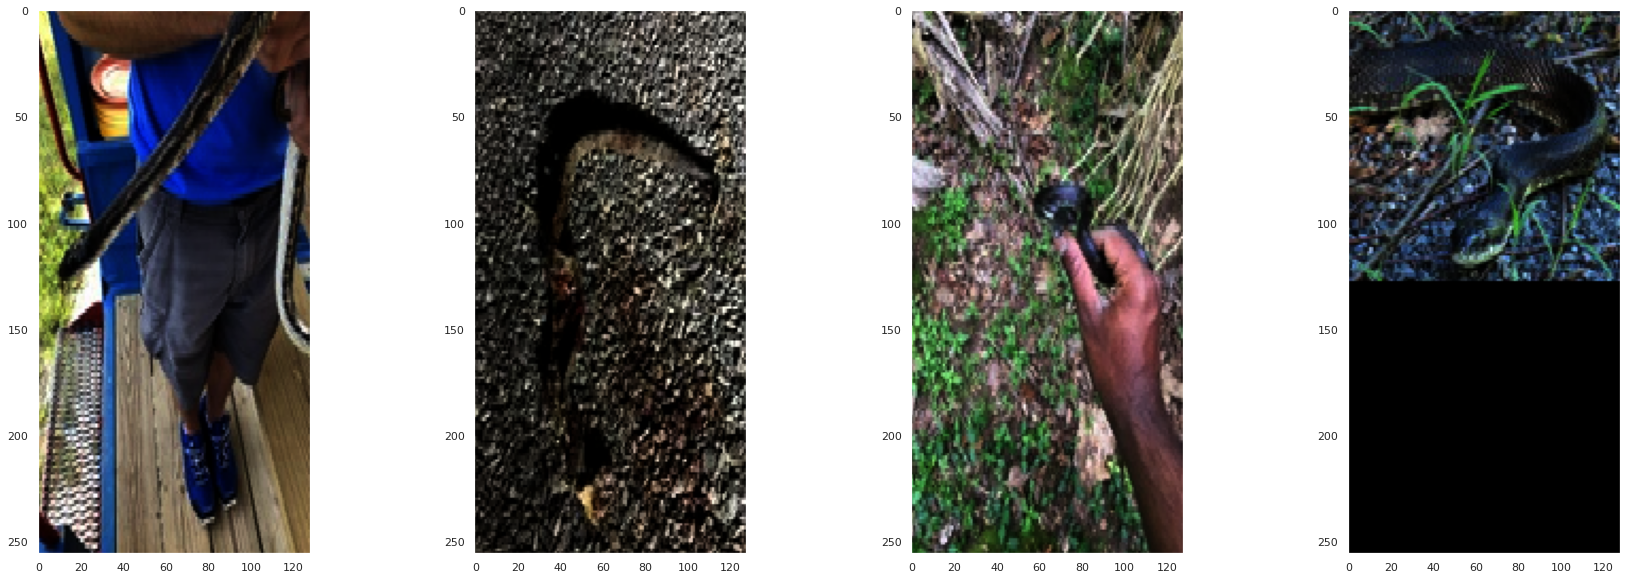

In [29]:
_, ax = plt.subplots(1, 4, figsize=(30, 10))
ax[0].imshow(Xpredict[10]); ax[0].grid(False);
ax[1].imshow(Xpredict[100]); ax[1].grid(False);
ax[2].imshow(Xpredict[500]); ax[2].grid(False);
ax[3].imshow(Xpredict[1500]); ax[3].grid(False);